# Dos Analyser
  


# Changelog
- Removed external dependencies (input files) by downloading calculations on demand, <br>
  via `requests` module, from NOMAD's Archive & Repository.
- All downloads or figure files are saved to `./workdir/`, which is listed in a `.gitignore`

# Notes
This notebook makes large use of python's `requests` module to download data from [NOMAD's Archive & Repository (link).](https://repository.nomad-coe.eu/app/api/)

- **Note on encodings:**
 "_HTML and XML have the ability to specify their encoding in their body. In situations like this, you should use `r.content` to find the encoding, and then set `r.encoding`. This will let you use `r.text`_ "[Ref: (requests quickstart)](https://requests.readthedocs.io/en/master/user/quickstart/)
 
 
- **root | tree** : "`ElementTree.fromstring()` _parses XML from a string directly into an `Element`, which is the root element of the parsed tree_ [hence we name the returned object as `root`]. _Other parsing functions may create an_ `ElementTree` [and their returned object would be conveniently named as `tree`]"

# Input Parameters

In [1]:
# Try to keep all calculation parameters in this cell

case = {}
case['upload_id'] = 'pT4cDgonSeK_RTagfGnz2g'
case['entry_id'] = 'PMtdh8FOg02FedbM5PRIf62yimVm'
case['calc_url'] = 'https://repository.nomad-coe.eu/app/gui/entry/id/pT4cDgonSeK_RTagfGnz2g/PMtdh8FOg02FedbM5PRIf62yimVm'


In [2]:
# Import all required modules, except for plotting
import json
import requests
import os.path
import numpy as np
import xml.etree.ElementTree as ET

# Unit Conversion Factors
from nomad.units import ureg
Ha2eV = (1.0 * ureg.a_u_energy).to(ureg.eV).magnitude # Hartree to eV
J2eV = (1.0 * ureg.J).to(ureg.eV).magnitude # Joules to eV

# URLs to NOMAD's Archive & Repo
nomad_rae = 'http://nomad-lab.eu/prod/rae/api/raw' # bundle, ZIP

nomad_app = 'https://repository.nomad-coe.eu/app/api/' # single file
nomad_arx = nomad_app + 'archive/' # processed calc's
nomad_rep = nomad_app + 'repo/'    # calc's metadata
nomad_raw = nomad_app + 'raw/'     # unprocessed calc's


# FUNCTIONS


In [3]:
def url_fetch_file(case, fname, verbose=False):
    '''
    fetch file `fname` from NOMAD's archive, via requests
    '''
    upload_id = case['upload_id']
    entry_id = case['entry_id']
    
    # Fetch the calculation metadata 
    url = nomad_rep + upload_id + '/' + entry_id 
    metadata = requests.get(url).json()

    # pick up filename path from metadata
    calc_path = os.path.dirname(metadata['mainfile'] ) 
    fname_full = calc_path + '/' + fname

    # download fname as 'response' object
    url = nomad_raw + upload_id + '/' + fname_full
    response = requests.get(url)
    
    if verbose:
        print('type(response): ', type(response))
        print('Received encoding:', response.encoding) # see note below
    return response
# ------

def xml_find_dos(root, verbose=False):
    '''
    root: an xml root object
    returns: a tuple (True|False, level), where `level` is the depth
    at which `totaldos` was found
    '''
    if verbose:
        print('[TAG] \t\tATTRIBUTE')
    level = 0
    for child in root:
        if verbose:
            print('[{:10s}]\t{}'.format(child.tag, child.attrib) )
        if child.tag == 'totaldos':
            print('`totaldos` found at level {}'.format(level))
            return (True, level)
        level += 1
# - - -        


def xml_dos_dimensions(root, verbose=False):
    '''
    Determine spin_count and energy_points  
    root: a xml root object
    '''
    spin_count = 0
    energy_points = 0
    
    # There is one 'diagram' per spin
    # root.iter() does deep search
    for diag in root.iter('diagram'):
        spin_count += 1
        
        if energy_points ==0:
            energy_points = len(diag.findall('point') )
        else:
            # paranoic check: both spins have same num ene points
            assert energy_points ==len(diag.findall('point') )
            
        if verbose:
            print('nspin: {}, size:{} ' .format(spin_count, energy_points))
    return (spin_count, energy_points )  
# ---

def fetch_dos_section(sscc, dos_type, verbose=False):
    '''
    Finds and returns `dos_energies` and `dos_values` from a 
    given `sscc` list. The later comes from a 
    NOMAD's json output. 
    '''
    
    item_count = 0
    assert (dos_type in ['raw', 'normalized'])
    
    def set_keynames(dos_type, dos_dict):
        ''' 
        Set key names (strings). Handles cases where 
        normalized data is requested but 
        `dos_energies_normalized` is absent
        '''
        if dos_type == 'raw':
            dos_ene = 'dos_energies'
            dos_vals = 'dos_values'
        # 'raw' type always contains previous key names
        # however, 'normalized' type might have or not the '_normalized'
        # appendix, or don't have the energies array. Hence, a few checks
        # are in place
        elif dos_type == 'normalized': 
            dos_vals = 'dos_values_normalized'
            
            # there're two alternatives for the energy counterpart
            if 'dos_energies_normalized' in dos_dict:
                dos_ene = 'dos_energies_normalized'
            elif 'dos_energies' in dos_dict:
                # fall back
                dos_ene = 'dos_energies'
            else:
                dos_ene = None
        # ---
        return dos_ene, dos_vals        
    # ---

    # sscc: list of dictionaries
    for item in sscc:
        if verbose:
            print('item_count:', item_count)
            
        if 'section_dos' in item:
            dos_dict = item['section_dos'][0]
            
            if 'gw_self_energy_c' not in item:
                print('sscc no. {}: section_dos found' .format(item_count))
                dos_ene, dos_vals = set_keynames(dos_type, dos_dict)
                
                ########
                energy_pts = len(dos_dict[dos_ene])
                spin_count = len(dos_dict[dos_vals])
                
                dos_energies = np.zeros((energy_pts))
                dos_values = np.zeros((energy_pts, spin_count))
                
                # store data                
                dos_energies[:] = dos_dict[dos_ene]  
                for spin in range(spin_count):
                    dos_values[:,spin] = dos_dict[dos_vals][spin] 
                    
            elif 'gw_self_energy_c' in item:  
                # This `elif` branch might become unnecessary if we can confirm 
                # that GW SSCC shouldn't contain any dos_section.
                pass
                
        else:
            print('sscc no. {}: section_dos absent' .format(item_count))
        item_count += 1

    return (dos_energies, dos_values )


# 1. RAW DFT
Download a DOS calculation, verbatim, as produced by the DFT code.

We only download the DOS data file.

In [4]:
# WARNING: This cell downloads an exciting DOS file (XML format).
#          Other DFT codes might use other file formats.          

# fetch the DOS data file
dos_datafile = 'dos.xml' # an exciting dos file

# next line is dft-code independent
response_dos = url_fetch_file(case, dos_datafile, verbose=True)

# Use the 'ElementTree XML API'
root = ET.fromstring(response_dos.content)

spin_count, energy_points = xml_dos_dimensions(root)
print('spin_count:   ', spin_count)
print('energy_points:', energy_points)

# create arrays
dos_energies_raw = np.zeros((energy_points))
dos_values_raw = np.zeros((energy_points, spin_count))

# fill in arrays
for td in root.findall('totaldos'):
    for diag in td.findall('diagram'):
        # nspin is the spin index, not spin_count
        # also, 1<= nspin <= spin_count <=2
        nspin = int(diag.get('nspin'))
        for pt in range(energy_points):
            point = diag[pt]
            dos_energies_raw[pt] = point.get('e')
            dos_values_raw[pt, nspin-1] = point.get('dos')
            

# unit conversion
dos_energies_raw *= Ha2eV 
dos_values_raw /= Ha2eV

# ALERT: exciting code reports DOS values shifted by Fermi energy.

type(response):  <class 'requests.models.Response'>
Received encoding: utf-8
spin_count:    1
energy_points: 500


# 2. Archive 
## Fetch (parsed) Metainfo from Archive


In [5]:
# WARNING: This cell is DFT-code independent (any calc in NOMAD's archive)

# fetch metadata
upload_id = case['upload_id']
entry_id = case['entry_id']
url = nomad_arx + upload_id +'/' + entry_id
print('url: {}\n' .format(url))

metadata = requests.get(url).json()

sscc_str = 'section_single_configuration_calculation'
sscc_list = metadata['section_run'][0][sscc_str]   

dos_type = ['raw', 'normalized'][0]   
dos_sec = fetch_dos_section(sscc_list, dos_type, verbose=False)

dos_energies_arx, dos_values_arx = dos_sec

# unit conversion    
dos_energies_arx *= J2eV
dos_values_arx /= J2eV

url: https://repository.nomad-coe.eu/app/api/archive/pT4cDgonSeK_RTagfGnz2g/PMtdh8FOg02FedbM5PRIf62yimVm

sscc no. 0: section_dos found
sscc no. 2: section_dos absent


# Parse programatically 
### 1. Download calculation

In [6]:
import sys
from nomad.cli.parse import parse, normalize_all

code='exciting'
if code=='exciting':
    fnames = ['INFO.OUT', 'dos.xml']
    
outdir = './workdir/'
for fname in fnames:   
    response = url_fetch_file(case, fname, verbose=False)
    outfile = outdir + fname
    with open(outfile, 'w') as fh:
        print('Saving file: ', outfile)
        fh.write(response.text)
# - - -


Saving file:  ./workdir/INFO.OUT
Saving file:  ./workdir/dos.xml


### 2. Parse downloaded calculation

see the [documentation](https://nomad-lab.eu/prod/rae/docs/client/parsers.html)

In [7]:
mainfile = outdir + fnames[0]   
print(f'mainfile: {mainfile}')

# match and run the parser
archive = parse(mainfile)

normalize_all(archive)

# get the 'main section' section_run as a metainfo object
section_run = archive.section_run[0]

# get the same data as JSON serializable Python dict
python_dict = section_run.m_to_dict()   


mainfile: ./workdir/INFO.OUT


### 3. Pick-up dos data

In [8]:
sscc_str = 'section_single_configuration_calculation'
sscc_list = python_dict[sscc_str]

dos_type = ['raw', 'normalized'][0]   
dos_sec = fetch_dos_section(sscc_list, dos_type, verbose=False)

dos_energies_now, dos_values_now = dos_sec

# unit conversion    
dos_energies_now *= J2eV
dos_values_now /= J2eV

sscc no. 0: section_dos found


# PLOTS


### Data arrays
```
- dos_energies_raw , dos_values_raw
- dos_energies_arx , dos_values_arx  
- dos_energies_now, dos_values_now
```
### Keys:
- `'raw'`:  raw-calc downloaded from repo
- `'now'`:  freshly parsed 'raw' (raw-calc downloaded from repo)
- `'arx'`:  parsed-calc downloaded from archive

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']= [9.0, 6.0]

# Data Structures
dosene={}
dosene['raw'] = dos_energies_raw
dosene['arx'] = dos_energies_arx
dosene['now'] = dos_energies_now

dosvals={}
dosvals['raw'] = dos_values_raw
dosvals['arx'] = dos_values_arx
dosvals['now'] = dos_values_now

print('key\t dos_energies \t dos_values\t dos_values.max')
for key in dosene.keys():
    print('{}\t{:12s}\t{}\t{:.4g}' .format(key, str(dosene[key].shape), dosvals[key].shape,
                                           dosvals[key].max()))
    assert (dosene[key].max() > 0.0)
    assert (dosene[key].max() > 0.0)

print('-----')
print('\nRemove cell normalization from `raw`:')
x_exciting_unit_cell_volume = 4.004791738111699e-29
dosvals['raw'] = dosvals['raw'] * x_exciting_unit_cell_volume
print('key\t dos_energies \t dos_values\t dos_values.max')
for key in dosene.keys():
    print('{}\t{:12s}\t{}\t{:.4g}' .format(key, str(dosene[key].shape), dosvals[key].shape, 
                                           dosvals[key].max()))
    assert (dosene[key].max() > 0.0)
    assert (dosene[key].max() > 0.0)


key	 dos_energies 	 dos_values	 dos_values.max
raw	(500,)      	(500, 1)	3.191
arx	(500,)      	(500, 2)	1.278e-28
now	(500,)      	(500, 2)	1.278e-28
-----

Remove cell normalization from `raw`:
key	 dos_energies 	 dos_values	 dos_values.max
raw	(500,)      	(500, 1)	1.278e-28
arx	(500,)      	(500, 2)	1.278e-28
now	(500,)      	(500, 2)	1.278e-28


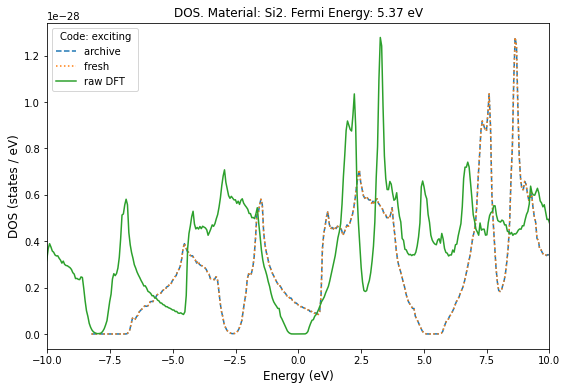

In [10]:

code='exciting'
fermi_eV ={}
fermi_eV[code] = 0.19731006767 * Ha2eV

def plot_all(dosene, dosvals, material, code, save_plot=False):
    
    for zoom in [False]: # FIXME: [False, True], fix yrange
        delta = 0
        
        plt.figure()
        for source in [ 'arx', 'now', 'raw']:
            if code == 'exciting':
                lbl = '(unshifted)'
            else:
                lbl = ''
            factor = 1.0
            if source == 'raw':
                line = '-'
                lbl = 'raw DFT'
            elif source == 'arx':
                line = '--'
                lbl = 'archive '
            elif source == 'now':
                line = ':'   
                lbl = 'fresh'
                factor = 1.0
                #dosene['par'] -= fermi_eV[code]
                
            plt.plot(dosene[source][:], 
                     dosvals[source][:,0] * factor, line,
                    label=r'{:10s}'.format(lbl))      
        
        if zoom:
            plt.xlim(-2,2)
            ymax = max(0, dosvals['raw'].max())
            plt.ylim(0, 1.3e-28)
            title_appendix = 'ZOOM IN'
        else:  
            plt.xlim(-10,10)
            title_appendix = ''
        # - - -
        
        ttl = 'DOS. Material: {}. Fermi Energy: {:.2f} eV' .format(material, fermi_eV[code], title_appendix)
        plt.title(ttl)
        plt.xlabel('Energy (eV)', size=12)
        plt.ylabel('DOS (states / eV)', color='k', size=12)
        
        plt.legend(title='Code: {}' .format(code))
      
        if save_plot:
            # goes before show()
            filename =  BASE+'outplots/dos_rawdft_{}.png' .format('ALL_ZOOM')
            plt.savefig( filename , bbox_inches='tight')
        plt.show()
# -------

material = 'Si2'
code = 'exciting'
plot_all(dosene, dosvals, material, code)

# Quick Checks

In [11]:
#Only Archive vs Parsed

if 1==0:
    plt.figure()
    plt.plot(dos_energies_arch , dos_values_arch)

    # new figure
    plt.figure() #dosene['par'] -= fermi_eV[code]
    plt.plot(dos_energies_parsed - fermi_eV[code], 
             dos_values_parsed )

---
---


# DIFFERENT CODES &<br> SIMILAR CALCULATIONS

In [12]:
def plot_all(dos_dft, material, source, save_plot):
    '''
    Plots DOS for different DFT codes
    This example iterates over ['aims', 'exciting', 'vasp']'
    
    Parameters
    ----------
    dos_dft : dictionary
        dos data.
    material : string
        Label for plot's title.
    save_plot : boolean
        Specify if a figure .

    Returns
    -------
    None.
    '''
    
    for zoom in [False]: #, True]:
        delta = 0
        
        plt.figure()
        for code in ['aims', 'exciting', 'vasp']:
            if code == 'exciting':
                lbl = '(unshifted)'
            else:
                lbl = ''
        
        
            plt.plot(dos_dft[code][:,0],
                     dos_dft[code][:,1],
                    label=r'{:10s} {}'.format(code, lbl))
        
            #txt = '{} EFermi {:.2f} eV' .format(code, fermi_eV[code])
            #plt.text(0.5, 0.4-delta, txt)
           # delta -= 0.03
        
        if zoom:
            plt.xlim(-1,1)
            plt.ylim(-.02, .5)
            title_appendix = 'ZOOM IN'
        else:  
            plt.xlim(-10,10)
            title_appendix = ''
        # - - -
        
        plt.title('Source: {}. Material: {}. {}' .format(source, material, title_appendix))
        plt.xlabel('Energy (eV)', size=12)
        plt.ylabel('DOS (states / eV)', color='k', size=12)
        
        plt.legend(title='Code')
      
        if save_plot:
            # goes before show()
            filename =  BASE+'outplots/dos_rawdft_{}.png' .format('ALL_ZOOM')
            plt.savefig( filename , bbox_inches='tight')
        plt.show()
# -------


# Fetch from Archive: 3 codes
## Fetch (parsed) Metainfo from Archive



In [13]:
def archive_fetch_calc(case, normalized=False, verbose=False):
    '''
    Fetch processed calculation from NOMAD's archive
    Avoid unit conversions, since these depend on the DFT code
    '''
    upload_id = case['upload_id']
    entry_id = case['entry_id']
    
    # fetch metadata
    url = nomad_app + 'archive/' + upload_id +'/' + entry_id
    metadata = requests.get(url).json()

    if verbose:
        print('\n', url)
        
    sscc_str = 'section_single_configuration_calculation'
    sscc_list = metadata['section_run'][0][sscc_str]

    # print(type(sscc_list))    

    # dos_type = ['raw', 'normalized'][0] 
    if normalized:
        dos_type = 'normalized'
    else:
        dos_type = 'raw'
            
    dos_energies, dos_values = fetch_dos_section(sscc_list, dos_type)

    # unit conversion (archive is always in SI units)   
    dos_energies *= J2eV
    dos_values /= J2eV

    # dos.shape = {(n,2) or (n,3)}
    # col 1: energies, cols 2-3: dos_values 
    dos = np.vstack((dos_energies, dos_values.T)).T
    return dos
#-------



In [14]:
#########
# Data Structures
#########
dos_arch_raw={}
dos_arch_norm={}


#########
# exciting
#########
case = {}
case['upload_id'] = 'pT4cDgonSeK_RTagfGnz2g'
case['entry_id'] = 'PMtdh8FOg02FedbM5PRIf62yimVm'
case['calc_url'] = 'https://repository.nomad-coe.eu/app/gui/entry/id/pT4cDgonSeK_RTagfGnz2g/PMtdh8FOg02FedbM5PRIf62yimVm'

dos_arch_raw['exciting'] = archive_fetch_calc(case, normalized=False)
dos_arch_norm['exciting'] = archive_fetch_calc(case, normalized=True)

#########
# FHI-AIMS
#########
case = {}
case['upload_id'] = 'uCSlNMEWQfOS5TMvsQXz1A'
case['entry_id'] = 'hpUk30zGCNI6gYMRAYIr-j0MII0d'
case['calc_url'] = 'https://repository.nomad-coe.eu/app/gui/entry/id/uCSlNMEWQfOS5TMvsQXz1A/hpUk30zGCNI6gYMRAYIr-j0MII0d'

dos_arch_raw['aims'] =  archive_fetch_calc(case, normalized=False)
dos_arch_norm['aims'] =  archive_fetch_calc(case, normalized=True)

cell_volume_aims = 1.8033346685485985e-28
#dos_arch[code][:,1 ] /= cell_volume_aims


#########
# VASP
#########
case = {}
case['upload_id'] = 'IxN_SXI0QlqRv6sdGLULfA'
case['entry_id'] = '7UCmdvcWkQ9GSqeciDJ0kpK3u6W3'
case['calc_url'] = 'https://repository.nomad-coe.eu/v0.8/gui/entry/id/IxN_SXI0QlqRv6sdGLULfA/7UCmdvcWkQ9GSqeciDJ0kpK3u6W3'

dos_arch_raw['vasp']  = archive_fetch_calc(case, normalized=False)
dos_arch_norm['vasp'] = archive_fetch_calc(case, normalized=True)

# quick checks
if 1==1:
    print('\nRAW DOS')
    print('\t\tShape\t dos.max()')
    for code in ['aims', 'exciting', 'vasp']:
        ene = dos_arch_raw[code][:,0]
        dos = dos_arch_raw[code][:,1]
        print('{:10s} ene: {}\t {}' .format(code, ene.shape, ene.max()))
        print('{:10s} dos: {}\t {}' .format(code, dos.shape, dos.max()))
        print('')
    #------
    print('\nNORMALIZED DOS')
    print('\t\tShape\t dos.max()')
    for code in ['aims', 'exciting', 'vasp']:
        ene = dos_arch_norm[code][:,0]
        dos = dos_arch_norm[code][:,1]
        print('{:10s} ene: {}\t {}' .format(code, ene.shape, ene.max()))
        print('{:10s} dos: {}\t {}' .format(code, dos.shape, dos.max()))
        print('')

sscc no. 0: section_dos found
sscc no. 2: section_dos absent
sscc no. 0: section_dos found
sscc no. 2: section_dos absent
sscc no. 0: section_dos found
sscc no. 0: section_dos found
sscc no. 0: section_dos found
sscc no. 0: section_dos found

RAW DOS
		Shape	 dos.max()
aims       ene: (1000,)	 10.0
aims       dos: (1000,)	 6.666676298687467e-29

exciting   ene: (500,)	 18.92035087549528
exciting   dos: (500,)	 1.277912681175228e-28

vasp       ene: (301,)	 17.5918
vasp       dos: (301,)	 9.303976673342951e-29


NORMALIZED DOS
		Shape	 dos.max()
aims       ene: (1000,)	 15.7957958
aims       dos: (1000,)	 0.739372055

exciting   ene: (500,)	 13.768961440470166
exciting   dos: (500,)	 1.5954795713984835

vasp       ene: (301,)	 11.9561
vasp       dos: (301,)	 1.1402



# Plot Raw (unnormalized) DOS 
### Separate plots, since different DFT codes might output results<br> in different units and/or normalizations

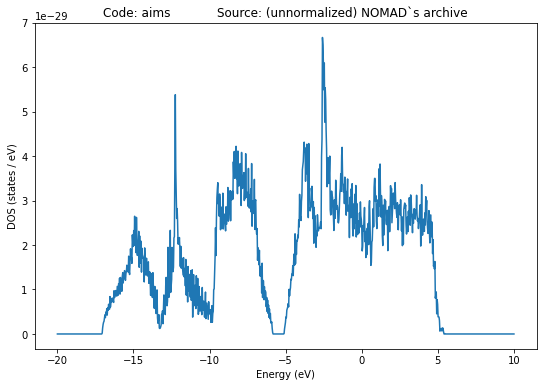

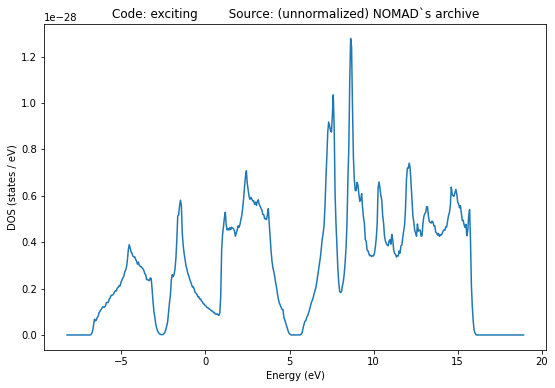

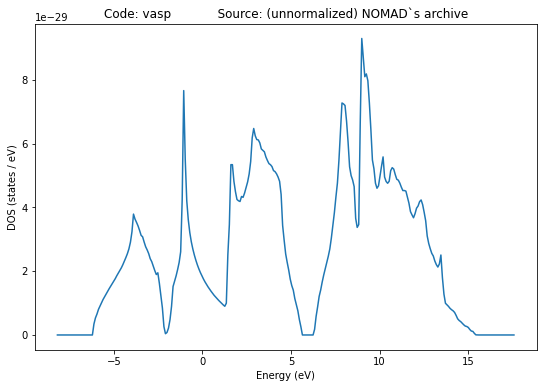

In [15]:
for code in ['aims', 'exciting', 'vasp']:
    ene = dos_arch_raw[code][:,0]
    dos = dos_arch_raw[code][:,1]
    plt.figure()
    plt.title('Code: {:15s} {}' .format(code, 'Source: (unnormalized) NOMAD`s archive'))
    plt.plot(ene, dos)
    plt.xlabel('Energy (eV)')
    plt.ylabel(r'DOS (states / eV)')

---
---

# Plot Normalized DOS
### One figure frame, since data ranges should lie on similar ranges


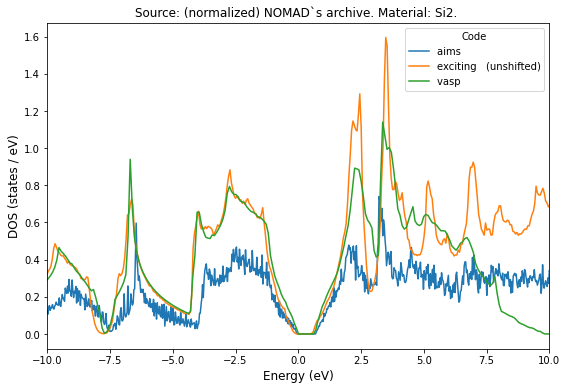

In [16]:

material='Si2'
source='(normalized) NOMAD`s archive'
plot_all(dos_arch_norm, material, source, save_plot=False)